#Trader Dataset Analysis via Python
This notebook will develop a general overview and perform three actions with the dataset:
1. Gather quantitative measures of aggressiveness for each of the traders in the dataset
2. Build a scatterplot and determine a LSRL to show the type of correlation between PNL and trader aggressiveness
3. Rank a selection of factors in how important they are in influencing PNL

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

#Load the dataset into a data frame
df = pd.read_csv("output.csv")
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

Basic Overview of the Dataset

In [2]:
print("Dataset Shape (rows, columns):", df.shape)
print("Columns:" + df.columns)
print(df.info())
print(df.describe())

Dataset Shape (rows, columns): (604578, 41)
Index(['Columns:trader', 'Columns:trader_pnl', 'Columns:trader_volume',
       'Columns:transaction_count', 'Columns:transactions_per_day',
       'Columns:volume_per_day', 'Columns:markets_per_day',
       'Columns:price_levels_consumed', 'Columns:price_levels_per_transaction',
       'Columns:price_levels_consumed_vw', 'Columns:mean_delta',
       'Columns:std_delta',
       'Columns:topic_arts, culture, entertainment and media',
       'Columns:topic_conflict, war and peace',
       'Columns:topic_crime, law and justice',
       'Columns:topic_disaster, accident and emergency incident',
       'Columns:topic_economy, business and finance',
       'Columns:topic_education', 'Columns:topic_environment',
       'Columns:topic_health', 'Columns:topic_human interest',
       'Columns:topic_labour', 'Columns:topic_lifestyle and leisure',
       'Columns:topic_politics', 'Columns:topic_religion',
       'Columns:topic_science and technology', 'Co

Action 1: Gather quantitative measures of aggressiveness for each of the traders in the dataset

In [ ]:
def mostAggressiveTraders():
    traderAgressivenessScores = {}

    for row in df.itertuples(index=True):
        #higher fraction means more price levels consumed per transaction, indicating larger orders and therefore more aggressiveness
        plcOverTransactions = (row.price_levels_consumed/row.transactions_per_day) if row.transactions_per_day != 0 else None
        lvlsPerTransaction = row.price_levels_per_transaction
        lvlsConsumedPerTransac_vw = row.price_levels_consumed_vw

        #distance from midpoint price indicates how much a trader is willing to sacrifice, measuring their riskiness and therefore aggression
        traderExitMeasure = row.mean_delta
        
        #account for zero division errors
        if(plcOverTransactions == None):
            traderAggressiveness = (lvlsPerTransaction * .15) + (lvlsConsumedPerTransac_vw * .17) + (traderExitMeasure * .15)
            traderAggressiveness += (row.transactions_per_day * .20) + (1/row.mean_time) * .13 + (math.log(row.markets_per_day + 1) * .20)
        else:
            traderAggressiveness = (plcOverTransactions * .18) + (lvlsPerTransaction * .15) + (lvlsConsumedPerTransac_vw * .12) + (traderExitMeasure * .10)
            traderAggressiveness += (row.transactions_per_day * .15) + (1/row.mean_time) * .10 + (math.log(row.markets_per_day + 1) * .20)

        traderAgressivenessScores[(row.trader, row.Index)] = traderAggressiveness


    sorted_traders = dict(sorted(traderAgressivenessScores.items(), key=lambda item: item[1], reverse=True))
    return sorted_traders
    
#Prints the top 5 most aggressive traders according to the algorithm in the dataset --> [("Trader Name", Trader Row in Dataset), Aggressiveness]
print(list(mostAggressiveTraders().items())[:5])



[(('0x9d84cE0306F8551e02EFef1680475Fc0f1dC1344', 245942), 92503.47978559675), (('0x96B59F71f635da5dA031e3E93448C54Fe226f5E7', 498158), 65934.48968178105), (('0x715e4430442e3c7bf152041ac5A1A9D9B234E9df', 222297), 49851.331698619215), (('0x3Cf3E8d5427aED066a7A5926980600f6C3Cf87B3', 549304), 49404.40431272793), (('0x7C3Db723F1D4d8cB9C550095203b686cB11E5C6B', 211461), 44406.51036608316)]


Action 2: Build a scatterplot and determine an LSRL to show the type of correlation between PNL and trader aggressiveness

In [29]:
%matplotlib inline

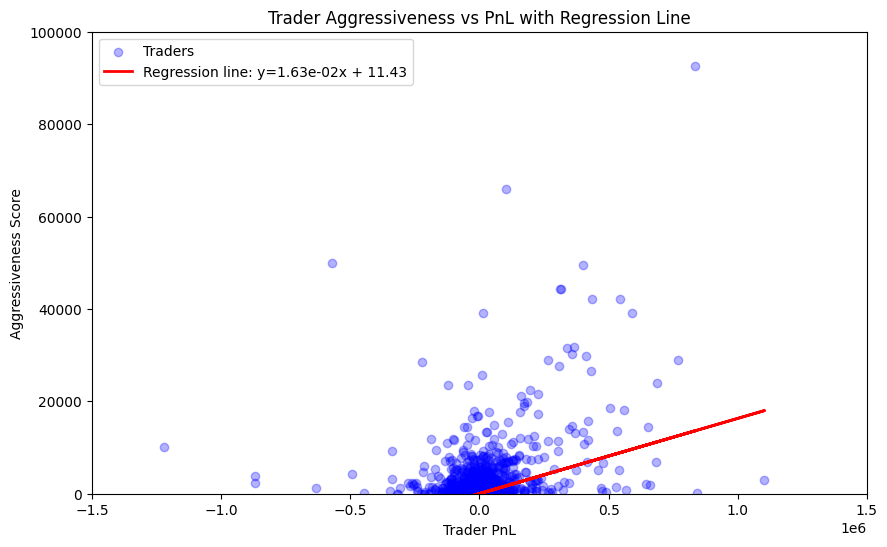

In [4]:
def aggressiveness_vs_pnl():
   
    # Map trader_id to pnl
    trader_to_pnl = {row.trader: row.trader_pnl for row in df.itertuples(index=True)}
    
    x = []
    y = []

    for trader_tuple, score in mostAggressiveTraders().items():
        trader_id = trader_tuple[0]  # extract trader_id from the key tuple
        pnl = trader_to_pnl.get(trader_id, 0)  # default to 0 if trader not found
        x.append(pnl)
        y.append(score)
    
    x = np.array(x)
    y = np.array(y)

    # Compute linear regression coefficients
    m, b = np.polyfit(x, y, 1)  # y = m*x + b

    # Plot scatter
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.3, color='blue', label='Traders')

    # Plot regression line
    plt.plot(x, m*x + b, color='red', linewidth=2, label=f'Regression line: y={m:.2e}x + {b:.2f}')

    # Set bounds
    plt.xlim(-1.5e6, 1.5e6)
    plt.ylim(0, 100000)

    # Labels
    plt.xlabel("Trader PnL")
    plt.ylabel("Aggressiveness Score")
    plt.title("Trader Aggressiveness vs PnL with Regression Line")
    plt.legend()
    plt.show()
    
aggressiveness_vs_pnl()

 Action 3:  Rank a selection of factors in how important they are in influencing PNL

In [5]:
#Note that because of the size of this data set and the number of trees generated, the run time will be long
def pnl_driver_analysis():
    features = [
        "trader_volume",
        "transactions_per_day",
        "markets_per_day",
        "price_levels_consumed",
        "price_levels_per_transaction",
        "price_levels_consumed_vw",
        "mean_delta",
        "std_delta"
    ]
    X = df[features].fillna(0)
    y = df["trader_pnl"]

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train Random Forest regressor
    rf = RandomForestRegressor(n_estimators=200, max_depth=10, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = rf.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Feature importances
    importances = rf.feature_importances_
    feature_importance_dict = {feat: imp for feat, imp in zip(features, importances)}

    # Sort features by importance
    sorted_features = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

    print("Random Forest Feature Importances:")
    for feat, imp in sorted_features.items():
        print(f"{feat}: {imp:.4f}")

    print(f"\nR^2: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")

pnl_driver_analysis()

Random Forest Feature Importances:
trader_volume: 0.4123
price_levels_consumed_vw: 0.1165
mean_delta: 0.1020
markets_per_day: 0.0855
price_levels_consumed: 0.0764
std_delta: 0.0732
price_levels_per_transaction: 0.0682
transactions_per_day: 0.0658

R^2: 0.1271
RMSE: 6870.28


Summary of Findings:
1. The 5 traders with the highest aggression (Encrypted Name, row in dataset) are:
   - ('0x9d84cE0306F8551e02EFef1680475Fc0f1dC1344', 245942) --> 92503.47978559675
   - ('0x96B59F71f635da5dA031e3E93448C54Fe226f5E7', 498158) --> 65934.48968178105
   - ('0x715e4430442e3c7bf152041ac5A1A9D9B234E9df', 222297) --> 49851.331698619215
   - ('0x3Cf3E8d5427aED066a7A5926980600f6C3Cf87B3', 549304) --> 49404.40431272793
   - ('0x7C3Db723F1D4d8cB9C550095203b686cB11E5C6B', 211461) --> 44406.51036608316

2. The scatterplot from Action 2 provides us with:
   - The LSRL --> y = 1.63e-02(x) + 11.43
   - Positive Correlation between a Trader's PNL and their aggressiveness score
   
3. Regressions from Action 3 reveal that:
   - Trader volume is the biggest factor that drives trader profit and loss of the following factors:
         - trader_volume, transactions_per_day, markets_per_day, price_levels_consumed, price_levels_per_transaction,                                  price_levels_consumed_vw, mean_delta, std_delta
   - Only about 13% of the change in trader PNL can be explained by these 8 factors --> there are likely thousands of outside factors
   - Predictions made by the model for PNL are off by 6870.28 on average